# HSI Dataset + AI training

## Loading cubes 

In [308]:
import os
import numpy as np
import matplotlib.pyplot as plt


In [309]:
# folders_day_0 = [r"Datacubes\03_06_2025\Cropped_03062025_152045",]
# folders_day_1 = [r"Datacubes\04_06_2025\Cropped_04062025_133054", 
#                  r"Datacubes\04_06_2025\Cropped_04062025_133942",
#                  r"Datacubes\04_06_2025\Cropped_04062025_134921"
#                  ]
# folders_day_2 = [r"Datacubes\05_06_2025\Cropped_05062025_120810",
#                  r"Datacubes\05_06_2025\Cropped_05062025_120856",
#                  r"Datacubes\05_06_2025\Cropped_05062025_121305"
#                 ]


folders_day_0 = [r"C:\Users\moust\projects\AI trainen\Datacubes\03_06_2025\Cropped_03062025_152045",]
folders_day_1 = [r"C:\Users\moust\projects\AI trainen\Datacubes\04_06_2025\Cropped_04062025_133054", 
                 r"C:\Users\moust\projects\AI trainen\Datacubes\04_06_2025\Cropped_04062025_133942",
                 r"C:\Users\moust\projects\AI trainen\Datacubes\04_06_2025\Cropped_04062025_134921"
                 ]
folders_day_2 = [r"C:\Users\moust\projects\AI trainen\Datacubes\05_06_2025\Cropped_05062025_120810",
                 r"C:\Users\moust\projects\AI trainen\Datacubes\05_06_2025\Cropped_05062025_120856",
                 r"C:\Users\moust\projects\AI trainen\Datacubes\05_06_2025\Cropped_05062025_121305"
                ]

In [310]:
def load_npy_files(folder):
    # Alleen .npy files die 'roi' in de naam hebben
    # files = [f for f in os.listdir(folder) if f.endswith('.npy')]
    files = [f for f in os.listdir(folder) if f.endswith('.npy') and 'roi' in f.lower()]
    data = []
    for file in files:
        file_path = os.path.join(folder, file)
        cube = np.load(file_path)
        cube = np.clip(cube, 0, 4095)  # Clip values between 0 and 4095
        data.append(cube)
        print(f"Loaded {file} from {folder} with shape {cube.shape}")
    return data



In [311]:
cubes_day_0, cubes_day_1, cubes_day_2 = [], [], []


if __name__ == "__main__":
    
    # Load data from the specified folders
    for folder in folders_day_0:
        cubes_day_0.extend(load_npy_files(folder))
    for folder in folders_day_1:
        cubes_day_1.extend(load_npy_files(folder))
    for folder in folders_day_2:
        cubes_day_2.extend(load_npy_files(folder))
    # Cube dimensions: (width, bands, height)


print(cubes_day_0.__len__(), "cubes loaded for day 0")  

Loaded crop_000_roi_00.npy from C:\Users\moust\projects\AI trainen\Datacubes\03_06_2025\Cropped_03062025_152045 with shape (5, 224, 5)
Loaded crop_000_roi_01.npy from C:\Users\moust\projects\AI trainen\Datacubes\03_06_2025\Cropped_03062025_152045 with shape (5, 224, 5)
Loaded crop_000_roi_02.npy from C:\Users\moust\projects\AI trainen\Datacubes\03_06_2025\Cropped_03062025_152045 with shape (5, 224, 5)
Loaded crop_000_roi_03.npy from C:\Users\moust\projects\AI trainen\Datacubes\03_06_2025\Cropped_03062025_152045 with shape (5, 224, 5)
Loaded crop_000_roi_04.npy from C:\Users\moust\projects\AI trainen\Datacubes\03_06_2025\Cropped_03062025_152045 with shape (5, 224, 5)
Loaded crop_000_roi_05.npy from C:\Users\moust\projects\AI trainen\Datacubes\03_06_2025\Cropped_03062025_152045 with shape (5, 224, 5)
Loaded crop_000_roi_06.npy from C:\Users\moust\projects\AI trainen\Datacubes\03_06_2025\Cropped_03062025_152045 with shape (5, 224, 5)
Loaded crop_000_roi_07.npy from C:\Users\moust\projects

## Visualize cubes

In [312]:
# Function to visualize a single cube (width, bands, height) with a specific band

def visualize_cube(cube, band_index, title):
    if band_index < 0 or band_index >= cube.shape[1]:
        raise ValueError(f"Band index {band_index} is out of range for cube with shape {cube.shape}")
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cube[:, band_index, :], cmap='twilight_shifted', aspect='auto')
    plt.colorbar()
    plt.title(f"{title} - Band {band_index}")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

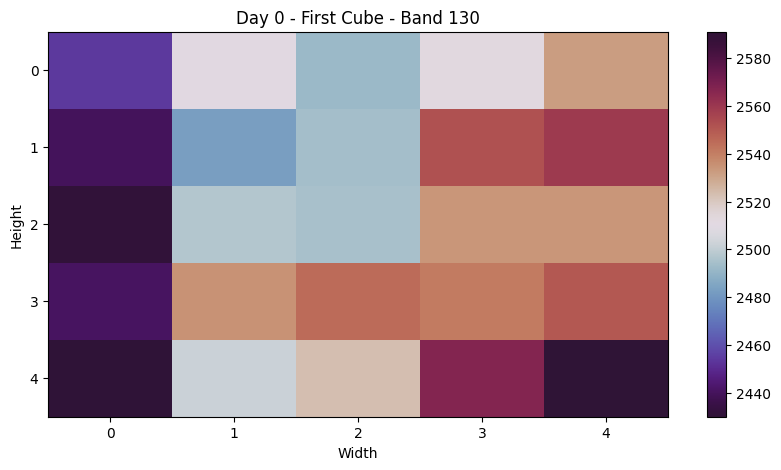

In [313]:
visualize_cube(cubes_day_0[0], 130, "Day 0 - First Cube")

## Remove background

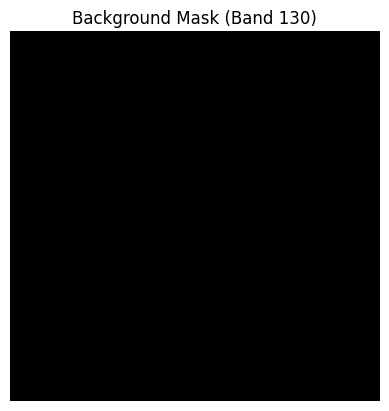

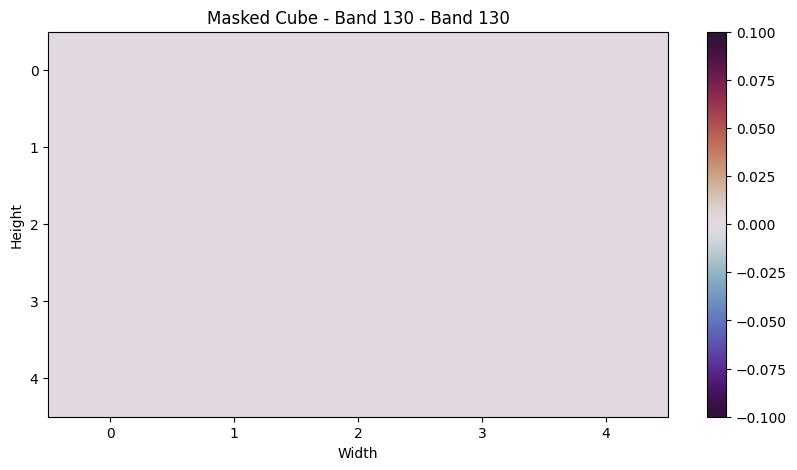

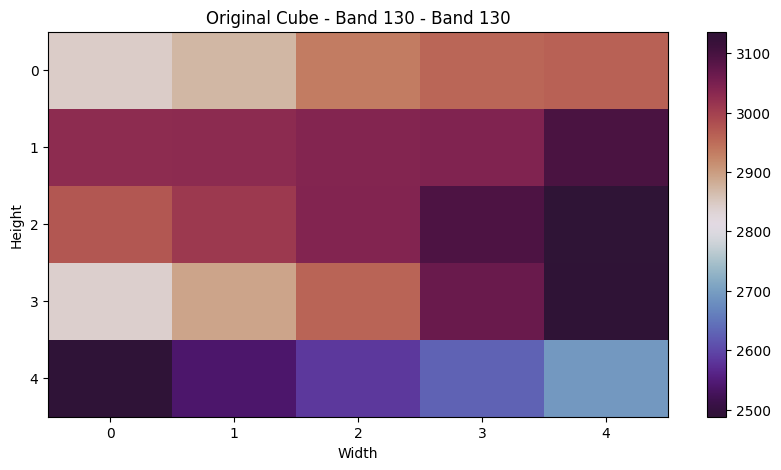

In [314]:
import numpy as np
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_opening, binary_closing

def mask_background_by_band(cube, band_index=130, invert=False, clean=True, structure_size=5):
    """
    Masks the background of a hyperspectral cube using thresholding on a specific spectral band.

    Parameters:
        cube (np.ndarray): Hyperspectral cube with shape (H, B, W).
        band_index (int): Band index to use for thresholding (default=130).
        invert (bool): Invert mask logic (useful if strawberries are darker than background).
        clean (bool): Apply morphological cleaning to mask.
        structure_size (int): Size of structuring element for cleaning.

    Returns:
        masked_cube (np.ndarray): Same shape as input cube, with background pixels zeroed out.
        mask (np.ndarray): Binary mask of shape (H, W) used for masking.
    """
    if cube.ndim != 3:
        raise ValueError("Cube must have shape (H, B, W)")

    H, B, W = cube.shape

    if band_index >= B:
        raise ValueError(f"Band index {band_index} is out of bounds for cube with {B} bands.")

    # Extract band image
    band_img = cube[:, band_index, :]  # (H, W)

    # Compute threshold
    threshold = threshold_otsu(band_img)
    mask = band_img > threshold if not invert else band_img < threshold

    # Clean mask
    if clean:
        structure = np.ones((structure_size, structure_size))
        mask = binary_closing(binary_opening(mask, structure=structure), structure=structure)

    # Apply mask to cube
    masked_cube = cube * mask[:, np.newaxis, :]

    return masked_cube, mask


masked_cube, mask = mask_background_by_band(cubes_day_1[5], band_index=130)

# Visualize the mask
import matplotlib.pyplot as plt

plt.imshow(mask, cmap='gray')
plt.title("Background Mask (Band 130)")
plt.axis('off')
plt.show()

# Visualize the masked cube
visualize_cube(masked_cube, 130, "Masked Cube - Band 130")

# Visualize the original cube for comparison
visualize_cube(cubes_day_1[5], 130, "Original Cube - Band 130")


In [315]:
# # remove background from all cubes
# for i, cube in enumerate(cubes_day_1):
#     masked_cube, mask = mask_background_by_band(cube, band_index=130)
#     cubes_day_1[i] = masked_cube
# # Visualize the first masked cube from day 1
# visualize_cube(cubes_day_1[0], 130, "Masked Cube Day 1 - Shape: " + str(cubes_day_1[0].shape))

## Reshape cube to X, y

In [316]:
# Initialize tracking lists
original_shapes = []
pixel_counts = []

# Function to reshape cube for X and record shape
def reshape_cube_for_x(cube):
    if len(cube.shape) != 3:
        raise ValueError(f"Cube must have 3 dimensions, got {len(cube.shape)} dimensions")
    
    H, W, B = cube.shape
    reshaped = cube.reshape(H * B, W)
    print(f"Reshaped cube from {cube.shape} to {reshaped.shape}")
    
    original_shapes.append((H, W, B))
    pixel_counts.append(H * B)
    
    return reshaped

# Process all cubes and store X and y
x_0 = [reshape_cube_for_x(cube) for cube in cubes_day_0]
x_1 = [reshape_cube_for_x(cube) for cube in cubes_day_1]
x_2 = [reshape_cube_for_x(cube) for cube in cubes_day_2]

# Create labels
y_0 = [np.zeros(H * B, dtype=int) for (H, W, B) in original_shapes[:len(cubes_day_0)]]
y_1 = [np.ones(H * B, dtype=int) for (H, W, B) in original_shapes[len(cubes_day_0):len(cubes_day_0)+len(cubes_day_1)]]
y_2 = [np.full(H * B, 2, dtype=int) for (H, W, B) in original_shapes[len(cubes_day_0)+len(cubes_day_1):]]

# Combine all into a single dataset
X = np.vstack(x_0 + x_1 + x_2)
y = np.concatenate(y_0 + y_1 + y_2)

# Final shape reporting
print(f"Final X shape: {X.shape}")
print(f"Final y shape: {y.shape}")
print(f"Unique labels in y: {np.unique(y)}")
print(f"Max value in X: {np.max(X)}")

Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) to (25, 224)
Reshaped cube from (5, 224, 5) t

## Normalize data

Values niet te hoog of niet te laag wordt

In [317]:
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Print the shape of the scaled dataset
print(f"Scaled X shape: {X_scaled.shape}")

print(np.mean(X_scaled), np.std(X_scaled))

print(np.min(X_scaled), np.max(X_scaled))

Scaled X shape: (18875, 224)
5.095472031278675e-18 1.0
-1.338334651607894 3.082138506972523


## PCA 

PCA X shape: (18875, 224)
Explained variance ratio: [8.58719365e-01 1.32859416e-01 3.95516490e-03 1.23266442e-03
 1.08065494e-03 8.69088904e-04 3.94212598e-04 2.99636198e-04
 1.29930515e-04 8.36442664e-05 7.32905303e-05 5.53217798e-05
 5.11836717e-05 3.92446353e-05 2.20195957e-05 1.83430281e-05
 1.75802136e-05 1.12047494e-05 1.03149153e-05 9.44021428e-06
 7.02894118e-06 6.11701752e-06 4.23957085e-06 3.72152060e-06
 3.44986147e-06 2.83138672e-06 1.81072112e-06 1.32017516e-06
 1.12075008e-06 9.38753925e-07 8.14536436e-07 6.70088641e-07
 6.63144596e-07 5.35053727e-07 5.24316629e-07 4.93774022e-07
 4.72139328e-07 4.51174787e-07 4.41753839e-07 4.25708901e-07
 4.01434882e-07 3.77097359e-07 3.55669614e-07 3.48806297e-07
 3.43445223e-07 3.26354939e-07 3.21211824e-07 3.14683842e-07
 3.12034781e-07 3.00029482e-07 2.91974079e-07 2.83109342e-07
 2.77492572e-07 2.74008174e-07 2.66318049e-07 2.64990306e-07
 2.59991750e-07 2.58128302e-07 2.51064306e-07 2.46743787e-07
 2.42855753e-07 2.42437801e-07 2.

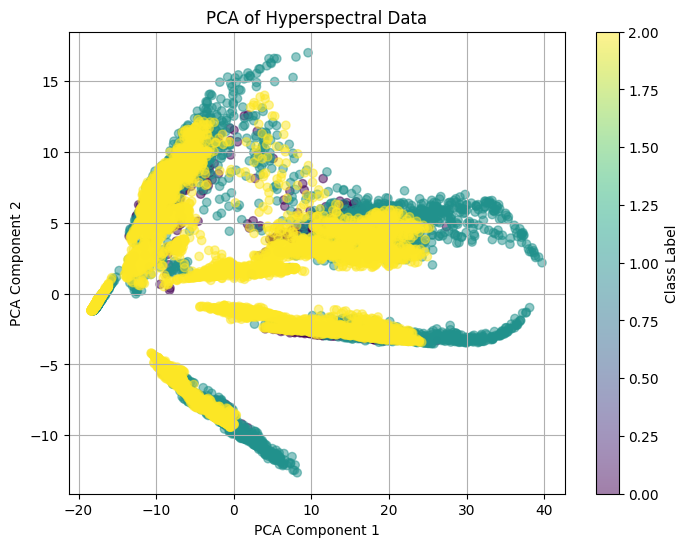

In [318]:
from sklearn.decomposition import PCA
# Apply PCA to reduce dimensionality
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
# Print the shape of the PCA transformed dataset
print(f"PCA X shape: {X_pca.shape}")
# Explained variance ratio per component
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class Label')
plt.title('PCA of Hyperspectral Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

-18.389307868881787 39.708880340484946
(18875, 224) (18875, 224)
First 5 labels in y: [0 0 0 0 0]
First 5 rows in X: [[ 253  255  261 ...  306  299  291]
 [ 300  288  315 ... 1878 1920 1899]
 [1913 1967 1960 ... 2534 2491 2517]
 [2533 2547 2566 ... 1831 1840 1779]
 [1783 1784 1820 ...  504  513  513]]
First 5 rows in X_pca: [[-1.79360785e+01 -1.06623092e+00 -1.12999458e+00 ...  1.84725173e-03
   9.69397393e-06  2.65687880e-04]
 [-9.69911525e+00  7.16528524e+00  7.38954343e-01 ... -2.89351949e-03
   2.41019317e-03 -1.14263250e-03]
 [ 1.11907251e+01  3.59811622e+00 -3.52219596e-01 ...  9.77943626e-03
   2.42005983e-03  4.07399844e-03]
 [ 1.20425960e+01 -2.77863860e+00 -5.64769304e-01 ... -9.62277564e-04
   9.01566127e-04  4.21482325e-03]
 [-5.55334430e+00 -7.13719147e+00  8.83808291e-01 ... -6.77015159e-03
  -8.81080555e-03 -2.32564739e-03]]
Last 5 labels in y: [2 2 2 2 2]
Last 5 rows in X: [[ 236  244  242 ...  346  365  345]
 [ 342  348  357 ... 1738 1749 1768]
 [1733 1725 1823 ... 236

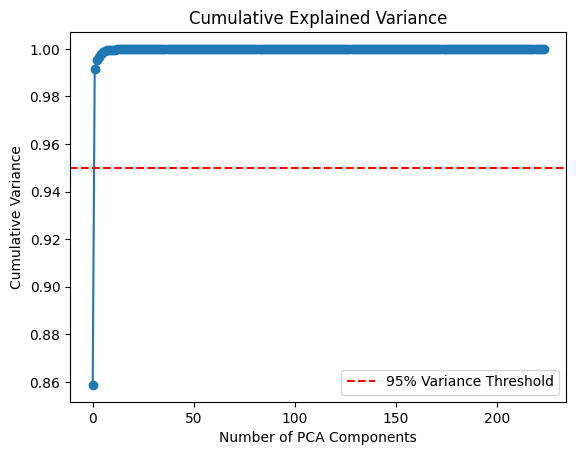

In [319]:
print(np.min(X_pca), np.max(X_pca))
print(X_scaled.shape, X_pca.shape)
print("First 5 labels in y:", y[:5])
print("First 5 rows in X:", X[:5])
print("First 5 rows in X_pca:", X_pca[:5])

print("Last 5 labels in y:", y[-5:])
print("Last 5 rows in X:", X[-5:])
print("Last 5 rows in X_pca:", X_pca[-5:])

ev=pca.explained_variance_ratio_ ; cumulative_ev = np.cumsum(ev)
# Plot the explained variance
plt.plot(cumulative_ev, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.show()


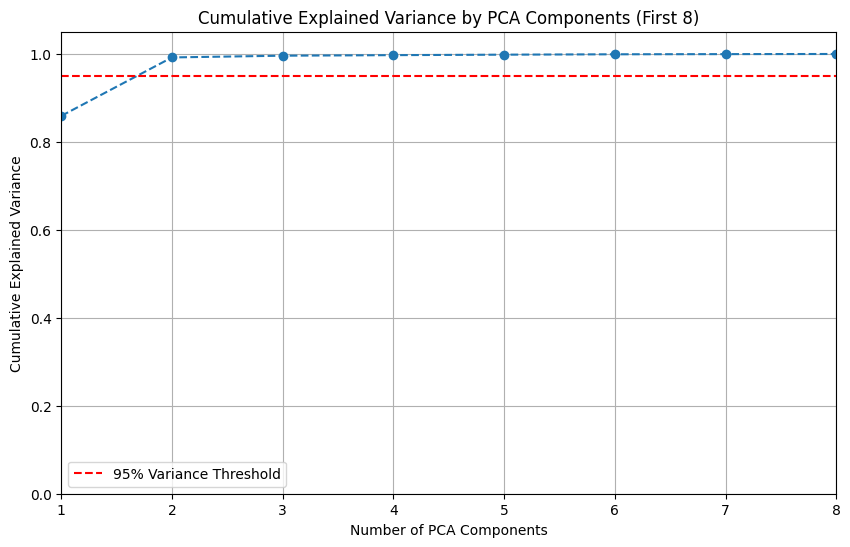

In [320]:
# Visualize the first 8 PCA components
pca = PCA(n_components=8)
pca.fit(X_scaled)
pca_components = pca.transform(X_scaled)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 9), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components (First 8)')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.xticks(range(1, 9))
plt.xlim(1, 8)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.show()


## Reshape PCA components into dimensions of the hyperspectral image (TODO)

## Training Split

In [321]:
# # Zet device op GPU als beschikbaar
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [322]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
# Print the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (15100, 224), y_train shape: (15100,)
X_test shape: (3775, 224), y_test shape: (3775,)


In [323]:
nComponents = 112
from sklearn.decomposition import PCA
pca = PCA(n_components=nComponents)
pca.fit(X_train)
pcaX_train = pca.transform(X_train)
print(f"PCA X_train shape: {pcaX_train.shape}")

PCA X_train shape: (15100, 112)


In [324]:
# from sklearn import svm

# # Train the SVM model
# classifier = svm.SVC(kernel='poly') # Nonlinear kernel
# classifier.fit(pcaX_train, y_train)


# pcaX_test = pca.transform(X_test)
# # Predict using the trained model
# y_pred = classifier.predict(pcaX_test)

# from sklearn.metrics import classification_report, confusion_matrix
# # Generate classification report
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# # Plot the confusion matrix
# import seaborn as sns
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # Save the trained model and PCA transformer
# import joblib
# # Save the SVM classifier
# joblib.dump(classifier, 'svm_classifier.pkl')
# # Save the PCA transformer
# joblib.dump(pca, 'pca_transformer.pkl')


In [325]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader

# # Zet device op GPU als beschikbaar
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("Using device:", device)

# # Zet data om naar torch tensors
# X_train_torch = torch.tensor(pcaX_train, dtype=torch.float32).to(device)
# y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
# X_test_torch = torch.tensor(pca.transform(X_test), dtype=torch.float32).to(device)
# y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)

# # DataLoader voor batching
# train_ds = TensorDataset(X_train_torch, y_train_torch)
# train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

# # Simpel feedforward netwerk
# class SimpleNet(nn.Module):
#     def __init__(self, input_dim, num_classes):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, num_classes)
#         )
#     def forward(self, x):
#         return self.net(x)

# model = SimpleNet(pcaX_train.shape[1], len(torch.unique(y_train_torch))).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Trainen
# epochs = 50
# for epoch in range(epochs):
#     model.train()
#     for xb, yb in train_dl:
#         optimizer.zero_grad()
#         out = model(xb)
#         loss = loss_fn(out, yb)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# # Evaluatie
# model.eval()
# with torch.no_grad():
#     y_pred = model(X_test_torch).argmax(dim=1).cpu().numpy()
#     y_true = y_test_torch.cpu().numpy()

# from sklearn.metrics import classification_report, confusion_matrix
# print("Classification Report:")
# print(classification_report(y_true, y_pred))
# conf_matrix = confusion_matrix(y_true, y_pred)
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

In [326]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import joblib

# # Train Random Forest on PCA features
# rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# rf.fit(pcaX_train, y_train)

# # Predict on test set
# pcaX_test = pca.transform(X_test)
# y_pred = rf.predict(pcaX_test)

# # Evaluation
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
# plt.title('Confusion Matrix (Random Forest)')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # Save the trained Random Forest model
# joblib.dump(rf, 'random_forest_classifier.pkl')

In [327]:
# import umap

# reducer = umap.UMAP()

# embedding = reducer.fit_transform(X_scaled)
# embedding.shape


In [328]:
# import seaborn as sns
# # Assign a color for each label
# colors = sns.color_palette("viridis", len(np.unique(y)))

# # Scatter plot with assigned colors
# plt.scatter(
#     embedding[:, 0], 
#     embedding[:, 1], 
#     c=y,  # Use the mapped colors
#     s=5, 
#     alpha=0.5
# )

In [329]:
# reducer = umap.UMAP(random_state=42)
# reducer.fit(X_scaled)

In [330]:
# umap.UMAP(a=None, angular_rp_forest=False, b=None,
#      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
#      local_connectivity=1.0, low_memory=False, metric='euclidean',
#      metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
#      n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
#      output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
#      set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
#      target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
#      transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [331]:
# embedding = reducer.fit_transform(X_train)
# assert(np.all(embedding == reducer.embedding_))
# X_train.shape, embedding.shape

In [332]:
# plt.scatter(
#     embedding[:, 0], 
#     embedding[:, 1], 
#     c=y_train,  
#     s=5, 
#     alpha=0.5
# )
# plt.gca().set_aspect('equal', adjustable='datalim')
# plt.colorbar(boundaries=np.arange(len(np.unique(y_train)) + 1) - 0.5, ticks=np.arange(len(np.unique(y))), label='Class Label')
# plt.title('UMAP Projection of Hyperspectral Data')

In [333]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import joblib
# import numpy as np
# from umap import UMAP

# # Apply UMAP for dimensionality reduction
# umap = UMAP(n_neighbors=15, n_components=2, random_state=42)
# umapX_train = umap.fit_transform(X_train)
# umapX_test = umap.transform(X_test)

# # Train Random Forest on UMAP features
# rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# rf.fit(umapX_train, y_train)

# # Predict on test set
# y_pred = rf.predict(umapX_test)

# # Evaluation
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
# plt.title('Confusion Matrix (Random Forest with UMAP)')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # Save the trained Random Forest model
# joblib.dump(rf, 'random_forest_classifier_umap.pkl')

In [334]:
# from sklearn import svm
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import joblib
# import numpy as np
# from umap import UMAP

# # Apply UMAP for dimensionality reduction
# umap = UMAP(n_neighbors=15, n_components=2, random_state=42)
# umapX_train = umap.fit_transform(X_train)
# umapX_test = umap.transform(X_test)

# # Train the SVM model
# classifier = svm.SVC(kernel='poly')  # Nonlinear kernel
# classifier.fit(umapX_train, y_train)

# # Predict using the trained model
# y_pred = classifier.predict(umapX_test)

# # Generate classification report
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
# plt.title('Confusion Matrix (SVM with UMAP)')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # Save the trained model and UMAP transformer
# joblib.dump(classifier, 'svm_classifier_umap.pkl')
# joblib.dump(umap, 'umap_transformer.pkl')

In [335]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# from umap import UMAP
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report, confusion_matrix

# # Set device to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("Using device:", device)

# # Apply UMAP for dimensionality reduction
# umap = UMAP(n_neighbors=15, n_components=10, random_state=42)
# umapX_train = umap.fit_transform(X_train)
# umapX_test = umap.transform(X_test)

# # Convert data to torch tensors
# X_train_torch = torch.tensor(umapX_train, dtype=torch.float32).to(device)
# y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
# X_test_torch = torch.tensor(umapX_test, dtype=torch.float32).to(device)
# y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)

# # DataLoader for batching
# train_ds = TensorDataset(X_train_torch, y_train_torch)
# train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

# # Simple feedforward network
# class SimpleNet(nn.Module):
#     def __init__(self, input_dim, num_classes):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, num_classes)
#         )
#     def forward(self, x):
#         return self.net(x)

# model = SimpleNet(umapX_train.shape[1], len(torch.unique(y_train_torch))).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Training
# epochs = 100
# for epoch in range(epochs):
#     model.train()
#     for xb, yb in train_dl:
#         optimizer.zero_grad()
#         out = model(xb)
#         loss = loss_fn(out, yb)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# # Evaluation
# model.eval()
# with torch.no_grad():
#     y_pred = model(X_test_torch).argmax(dim=1).cpu().numpy()
#     y_true = y_test_torch.cpu().numpy()

# # Generate classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred))

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
# plt.title('Confusion Matrix (Neural Network with UMAP)')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

In [336]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# # Set device to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("Using device:", device)

# # Convert data to torch tensors (NO UMAP)
# X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
# X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)

# # Handle class imbalance
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# # DataLoader for batching
# train_ds = TensorDataset(X_train_torch, y_train_torch)
# train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

# # Improved feedforward neural network
# class SimpleNet(nn.Module):
#     def __init__(self, input_dim, num_classes):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, num_classes)
#         )
#     def forward(self, x):
#         return self.net(x)

# # Model, loss, optimizer
# model = SimpleNet(X_train.shape[1], len(np.unique(y_train))).to(device)
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Training loop
# epochs = 100
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for xb, yb in train_dl:
#         optimizer.zero_grad()
#         out = model(xb)
#         loss = loss_fn(out, yb)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     avg_loss = total_loss / len(train_dl)
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# # Evaluation
# model.eval()
# with torch.no_grad():
#     y_pred = model(X_test_torch).argmax(dim=1).cpu().numpy()
#     y_true = y_test_torch.cpu().numpy()

# # Classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred))

# # Confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
# plt.title('Confusion Matrix (NN without UMAP)')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()


In [337]:
import numpy as np
import torch
from torch.utils.data import Dataset

class HSIPixelDataset(Dataset):
    def __init__(self, cubes, labels):
        self.patches = []
        self.labels = []

        for cube, label in zip(cubes, labels):
            # Ensure shape: (W, B, H) → (B, H, W)
            cube = np.transpose(cube, (1, 2, 0))  # Now: (224, 5, 5)
            # Add channel dimension: (1, D, H, W)
            patch = cube[np.newaxis, :, :, :]
            self.patches.append(patch)
            self.labels.append(label)  # Must be the class of center pixel

        self.patches = np.stack(self.patches)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        x = torch.tensor(self.patches[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


In [338]:
import torch.nn as nn

class HSI3DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(7, 3, 3), padding=(3, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.classifier(x)


In [339]:
# Assign labels
labels_day_0 = [0] * len(cubes_day_0)
labels_day_1 = [1] * len(cubes_day_1)
labels_day_2 = [2] * len(cubes_day_2)

# Combine all cubes and labels
all_cubes = cubes_day_0 + cubes_day_1 + cubes_day_2
all_labels = labels_day_0 + labels_day_1 + labels_day_2

    
    
# For 3D CNN, each cube should have the same size 
# Reshape all cubes to the same size 224 pixels x 224 bands x 15 pixels

target_shape = (15, 224, 15)  # (height, bands, width)
reshaped_cubes = []

# for cube in all_cubes:
#     # Check if cube is large enough in all dimensions
#     if cube.shape[0] >= 15 and cube.shape[1] >= 224 and cube.shape[2] >= 15:
#         # Crop to target shape
#         reshaped_cube = cube[:15, :224, :15]
#         reshaped_cubes.append(reshaped_cube)
#     else:
#         print(f"Skipping cube with shape {cube.shape} as it does not meet the required dimensions.")


# for cube in all_cubes:
#     # Check if cube is large enough in all dimensions
#     if cube.shape[0] >= 15 and cube.shape[1] >= 224 and cube.shape[2] >= 15:
#         # Crop to target shape
#         reshaped_cube = cube[:15, :224, :15]
#         # Normalize to [0, 1]
#         reshaped_cube = reshaped_cube.astype(np.float32) / 4095.0
#         reshaped_cubes.append(reshaped_cube)
#     else:
#         print(f"Skipping cube with shape {cube.shape} as it does not meet the required dimensions.")

augmented_cubes = []
augmented_labels = []  # if you have labels

for cube, label in zip(all_cubes, all_labels):  # assuming you have a labels array
    augmented_cubes.append(cube)
    augmented_labels.append(label)
    
    # Flip
    flipped = np.flip(cube, axis=2)
    augmented_cubes.append(flipped)
    augmented_labels.append(label)
    
    # Rotate
    rotated = np.rot90(cube, k=1, axes=(0, 2))
    augmented_cubes.append(rotated)
    augmented_labels.append(label)
    
    # Add more augmentations as needed


    
for i, cube in enumerate(augmented_cubes):
    print(f"Cube {i} shape: {cube.shape}")
for i, label in enumerate(augmented_labels):
    print(f"Label {i}: {label}")


Cube 0 shape: (5, 224, 5)
Cube 1 shape: (5, 224, 5)
Cube 2 shape: (5, 224, 5)
Cube 3 shape: (5, 224, 5)
Cube 4 shape: (5, 224, 5)
Cube 5 shape: (5, 224, 5)
Cube 6 shape: (5, 224, 5)
Cube 7 shape: (5, 224, 5)
Cube 8 shape: (5, 224, 5)
Cube 9 shape: (5, 224, 5)
Cube 10 shape: (5, 224, 5)
Cube 11 shape: (5, 224, 5)
Cube 12 shape: (5, 224, 5)
Cube 13 shape: (5, 224, 5)
Cube 14 shape: (5, 224, 5)
Cube 15 shape: (5, 224, 5)
Cube 16 shape: (5, 224, 5)
Cube 17 shape: (5, 224, 5)
Cube 18 shape: (5, 224, 5)
Cube 19 shape: (5, 224, 5)
Cube 20 shape: (5, 224, 5)
Cube 21 shape: (5, 224, 5)
Cube 22 shape: (5, 224, 5)
Cube 23 shape: (5, 224, 5)
Cube 24 shape: (5, 224, 5)
Cube 25 shape: (5, 224, 5)
Cube 26 shape: (5, 224, 5)
Cube 27 shape: (5, 224, 5)
Cube 28 shape: (5, 224, 5)
Cube 29 shape: (5, 224, 5)
Cube 30 shape: (5, 224, 5)
Cube 31 shape: (5, 224, 5)
Cube 32 shape: (5, 224, 5)
Cube 33 shape: (5, 224, 5)
Cube 34 shape: (5, 224, 5)
Cube 35 shape: (5, 224, 5)
Cube 36 shape: (5, 224, 5)
Cube 37 sha

In [340]:
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader


# # Split dataset (e.g. 80/20)
# cubes_train, cubes_test, labels_train, labels_test = train_test_split(
#     all_cubes, all_labels, test_size=0.2, stratify=all_labels, random_state=42
# )

# # Datasets
# train_dataset = HSIPixelDataset(cubes_train, labels_train)
# test_dataset = HSIPixelDataset(cubes_test, labels_test)

# # Dataloaders
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=128)


In [341]:
# y_all = train_dataset.labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_all), y=y_all)
weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

model = HSI3DCNN(num_classes=3).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [342]:
# epochs = 100
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     for xb, yb in train_loader:
#         xb, yb = xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         out = model(xb)
#         loss = loss_fn(out, yb)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     avg_loss = running_loss / len(train_loader)
#     print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")


In [343]:
# from sklearn.metrics import classification_report

# model.eval()
# all_preds, all_labels = [], []
# with torch.no_grad():
#     for xb, yb in test_loader:
#         xb = xb.to(device)
#         preds = model(xb).argmax(dim=1).cpu().numpy()
#         all_preds.extend(preds)
#         all_labels.extend(yb.numpy())

# print("Classification Report:")
# print(classification_report(all_labels, all_preds))


In [344]:
# # save the model
# import time

# save_folder = 'hsi_3d_cnn_model'
# import os
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)
    
# # Save the model state with timestamp
# model_save_path = os.path.join(save_folder, 'hsi_3d_cnn.pth_' + str(int(time.time())))
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

In [345]:
# # load the model
# model_path = r"hsi_3d_cnn_model\hsi_3d_cnn.pth_1749771618"

# model = HSI3DCNN(num_classes=3).to(device)
# model.load_state_dict(torch.load(model_path, map_location=device))
# # Set the model to evaluation mode
# from sklearn.metrics import classification_report

# model.eval()
# all_preds, all_labels = [], []
# with torch.no_grad():
#     for xb, yb in test_loader:
#         xb = xb.to(device)
#         preds = model(xb).argmax(dim=1).cpu().numpy()
#         all_preds.extend(preds)
#         all_labels.extend(yb.numpy())

# print("Classification Report:")
# print(classification_report(all_labels, all_preds))

In [352]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import random

# -------------------------
# Normalize cubes
# -------------------------
def normalize_cubes(cubes):
    mean = np.mean(cubes, axis=(0, 2, 3), keepdims=True)
    std = np.std(cubes, axis=(0, 2, 3), keepdims=True)
    return (cubes - mean) / (std + 1e-6)

# -------------------------
# Dataset class with augmentation
# -------------------------
class HSIPixelDataset(Dataset):
    def __init__(self, cubes, labels, augment=False):
        self.cubes = cubes.astype(np.float32)
        self.labels = np.array(labels).astype(np.int64)
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        cube = self.cubes[idx]
        label = self.labels[idx]
        if self.augment:
            cube = self.augment_cube(cube)
        return torch.tensor(cube.copy(), dtype=torch.float32), torch.tensor(label)

    def augment_cube(self, cube):
        if random.random() < 0.5:
            cube = np.flip(cube, axis=1)  # horizontal flip
        if random.random() < 0.5:
            cube = np.flip(cube, axis=2)  # vertical flip
        if random.random() < 0.3:
            noise = np.random.normal(0, 0.01, cube.shape)
            cube = cube + noise
        return cube

# -------------------------
# Refactored Model with Dropout + BatchNorm
# -------------------------
class HSI3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(HSI3DCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(32 * 1 * 1 * 56, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# -------------------------
# Prepare Data
# -------------------------
# Normalize first
all_cubes = normalize_cubes(all_cubes)

# Train/test split
cubes_train, cubes_test, labels_train, labels_test = train_test_split(
    all_cubes, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

train_dataset = HSIPixelDataset(cubes_train, labels_train, augment=True)
test_dataset = HSIPixelDataset(cubes_test, labels_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# -------------------------
# Model setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HSI3DCNN(num_classes=3).to(device)

# Class weights
y_all = train_dataset.labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_all), y=y_all)
weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Loss, optimizer, scheduler
loss_fn = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

# # -------------------------
# # Training loop
# # -------------------------
# best_acc = 0.0
# epochs = 300
# for epoch in range(300):
#     model.train()
#     running_loss = 0.0
#     for xb, yb in train_loader:
#         xb = xb.unsqueeze(1).to(device)  # (B, 1, C, H, W)
#         yb = yb.to(device)

#         optimizer.zero_grad()
#         out = model(xb)
#         loss = loss_fn(out, yb)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     scheduler.step()
#     avg_loss = running_loss / len(train_loader)
#     print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

#     # Evaluation
#     model.eval()
#     all_preds, all_labels_eval = [], []
#     with torch.no_grad():
#         for xb, yb in test_loader:
#             xb = xb.unsqueeze(1).to(device)
#             preds = model(xb).argmax(dim=1).cpu().numpy()
#             all_preds.extend(preds)
#             all_labels_eval.extend(yb.numpy())

#     from sklearn.metrics import accuracy_score
#     acc = accuracy_score(all_labels_eval, all_preds)
#     print(f"Validation Accuracy: {acc:.4f}")

#     # # Save best model
#     # if acc > best_acc:
#     #     best_acc = acc
#     #     torch.save(model.state_dict(), "best_hsi_model.pth")
#     #     print("✅ Saved new best model.")
    
#         # Save checkpoint if the model improves
#     if acc > best_acc:
#         best_acc = acc
#         checkpoint = {
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             'settings': {
#                 'input_dim': X_train.shape[1],
#                 'num_classes': len(np.unique(y_train)),
#                 'learning_rate': 1e-3,
#                 'device': str(device)
#             }
#         }
#         torch.save(checkpoint, "best_hsi_model.pth")
#         print(f"Checkpoint saved at epoch {epoch+1}")

# print("Training complete.")


# -------------------------
# Training loop with normalization stats saving
# -------------------------
best_acc = 0.0
epochs = 300
mean = np.mean(all_cubes, axis=(0, 2, 3), keepdims=True)
std = np.std(all_cubes, axis=(0, 2, 3), keepdims=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.unsqueeze(1).to(device)  # (B, 1, C, H, W)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels_eval = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.unsqueeze(1).to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels_eval.extend(yb.numpy())

    from sklearn.metrics import accuracy_score
    acc = accuracy_score(all_labels_eval, all_preds)
    print(f"Validation Accuracy: {acc:.4f}")

    # Save checkpoint if the model improves
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_hsi_model.pth")
        print(f"Checkpoint saved at epoch {epoch+1}")

print("Training complete.")


Epoch 1/300 | Loss: 1.4133
Validation Accuracy: 0.3245
Checkpoint saved at epoch 1
Epoch 2/300 | Loss: 1.0163
Validation Accuracy: 0.5166
Checkpoint saved at epoch 2
Epoch 3/300 | Loss: 0.9480
Validation Accuracy: 0.5298
Checkpoint saved at epoch 3
Epoch 4/300 | Loss: 0.9392
Validation Accuracy: 0.5099
Epoch 5/300 | Loss: 0.9046
Validation Accuracy: 0.5695
Checkpoint saved at epoch 5
Epoch 6/300 | Loss: 0.8789
Validation Accuracy: 0.5894
Checkpoint saved at epoch 6
Epoch 7/300 | Loss: 0.8626
Validation Accuracy: 0.5695
Epoch 8/300 | Loss: 0.8330
Validation Accuracy: 0.5232
Epoch 9/300 | Loss: 0.8179
Validation Accuracy: 0.5629
Epoch 10/300 | Loss: 0.7807
Validation Accuracy: 0.5430
Epoch 11/300 | Loss: 0.7743
Validation Accuracy: 0.5430
Epoch 12/300 | Loss: 0.7526
Validation Accuracy: 0.5894
Epoch 13/300 | Loss: 0.7429
Validation Accuracy: 0.5828
Epoch 14/300 | Loss: 0.7224
Validation Accuracy: 0.6623
Checkpoint saved at epoch 14
Epoch 15/300 | Loss: 0.7250
Validation Accuracy: 0.6225


In [347]:
# load the best model
model = HSI3DCNN(num_classes=3).to(device)
model.load_state_dict(torch.load("best_hsi__model.pth", map_location=device))

# Save state dict with timestamp
save_folder = 'hsi_3d_cnn_model'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
model_save_path = os.path.join(save_folder, 'best_hsi_3dcnn_model.pth_' + str(int(time.time())))
# torch.save(model.state_dict(), model_save_path)
torch.save({"state_dict": model.state_dict(), "normalization_stats": {"mean": mean, "std": std}}, "best_hsi_3dcnn_model.pth")
# Set the model to evaluation mode
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.unsqueeze(1).to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
        
# from sklearn.metrics import classification_report
# print("Classification Report:")
# print(classification_report(all_labels, all_preds))
# # Generate confusion matrix
# from sklearn.metrics import confusion_matrix
# conf_matrix = confusion_matrix(all_labels, all_preds)
# # Plot the confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
# plt.title('Confusion Matrix (Best HSI Model)')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy.core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# load test cubes
test_folder_0905 = r"Cropped_20250509_151112"

test_cubes = load_npy_files(test_folder_0905)

Loaded crop_000_roi_00.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_01.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_02.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_03.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_04.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_05.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_06.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_07.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_08.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_09.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_10.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_11.npy from Cropped_20250509_151112 with shape (5, 224, 5)
Loaded crop_000_roi_12.npy from Cropped_20250509_151

In [ ]:
# load the best model
model = HSI3DCNN(num_classes=3).to(device)
model.load_state_dict(torch.load("best_hsi_3dcnn_model.pth", map_location=device))
# Set the model to evaluation mode
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for cube in test_cubes:
        cube_tensor = torch.tensor(cube[np.newaxis, np.newaxis, :, :, :], dtype=torch.float32).to(device)
        preds = model(cube_tensor).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
# Print predictions
print("Predictions for test cubes:")
for i, pred in enumerate(all_preds):
    print(f"Cube {i}: Predicted class {pred}")
    
# print the number of predictions per class
from collections import Counter
class_counts = Counter(all_preds)
print("Class counts in predictions:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} predictions")


Predictions for test cubes:
Cube 0: Predicted class 1
Cube 1: Predicted class 1
Cube 2: Predicted class 1
Cube 3: Predicted class 1
Cube 4: Predicted class 1
Cube 5: Predicted class 1
Cube 6: Predicted class 1
Cube 7: Predicted class 1
Cube 8: Predicted class 1
Cube 9: Predicted class 1
Cube 10: Predicted class 1
Cube 11: Predicted class 1
Cube 12: Predicted class 1
Cube 13: Predicted class 1
Cube 14: Predicted class 1
Cube 15: Predicted class 1
Cube 16: Predicted class 1
Cube 17: Predicted class 1
Cube 18: Predicted class 1
Cube 19: Predicted class 1
Cube 20: Predicted class 1
Cube 21: Predicted class 1
Cube 22: Predicted class 1
Cube 23: Predicted class 1
Cube 24: Predicted class 1
Cube 25: Predicted class 1
Cube 26: Predicted class 1
Cube 27: Predicted class 1
Cube 28: Predicted class 1
Cube 29: Predicted class 1
Cube 30: Predicted class 1
Cube 31: Predicted class 1
Cube 32: Predicted class 1
Cube 33: Predicted class 1
Cube 34: Predicted class 1
Cube 35: Predicted class 1
Cube 36: P